In [1]:
import ROOT
import uproot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.22/08


In [40]:
sig_df = pd.read_pickle('Pkl_ips/SC_SUSY_227_5_mchi_60_all.pkl')
tt_df  = pd.read_pickle('Pkl_ips/SC_ttbar_all.pkl')
vv_df  = pd.read_pickle('Pkl_ips/SC_VV_all.pkl')
st_df  = pd.read_pickle('Pkl_ips/SC_ST_all.pkl')
sat_df = pd.read_pickle('Pkl_ips/SC_SAT_all.pkl')

In [41]:
root_file = uproot.open('Root_files/SUSY_227_5_60.root')['Step8']
sc_weight = root_file['sc_weight'].array() 

c_kk
c_kr
c_rk
c_nn
c_nk
c_kn
c_rr
c_rn
c_nr
cP_rk
cM_rk


ValueError: weights should have the same shape as x

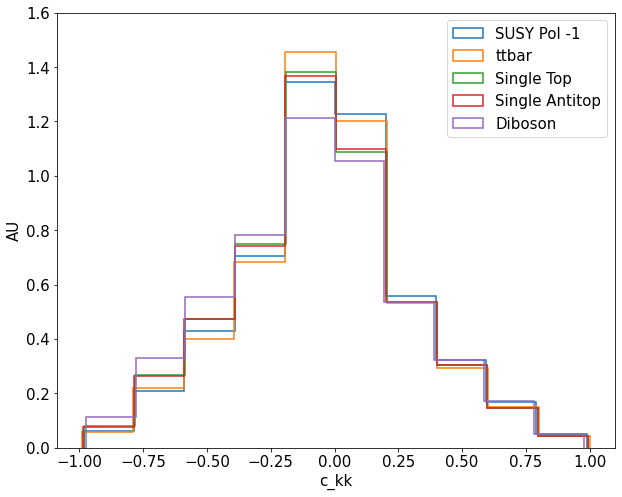

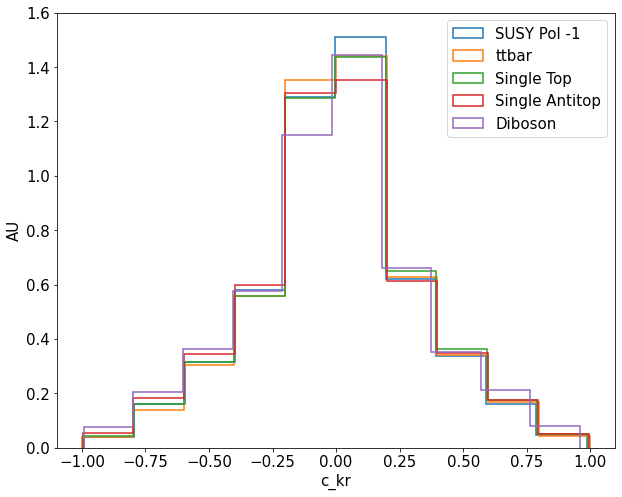

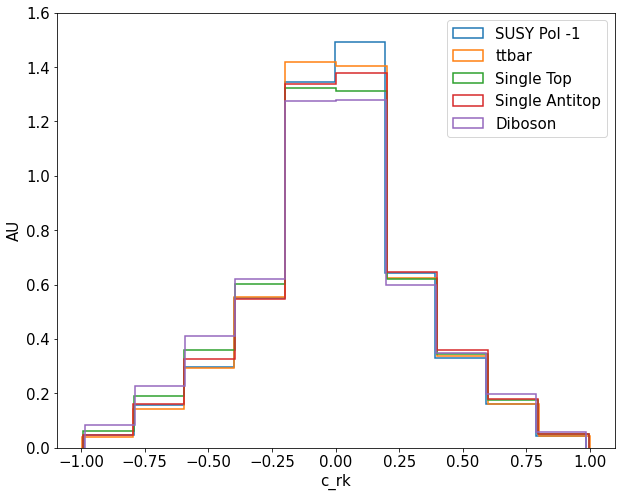

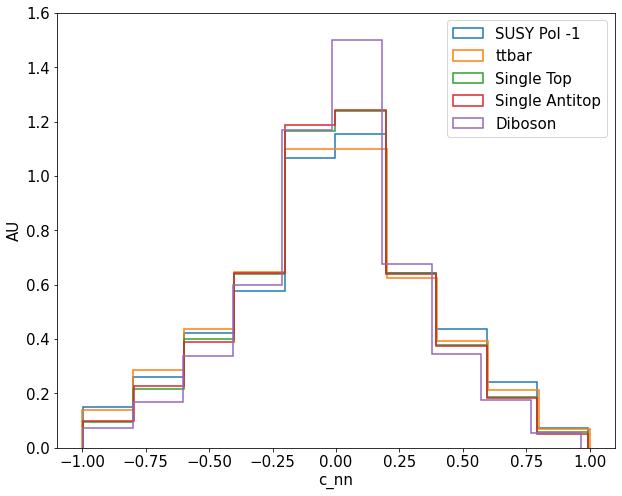

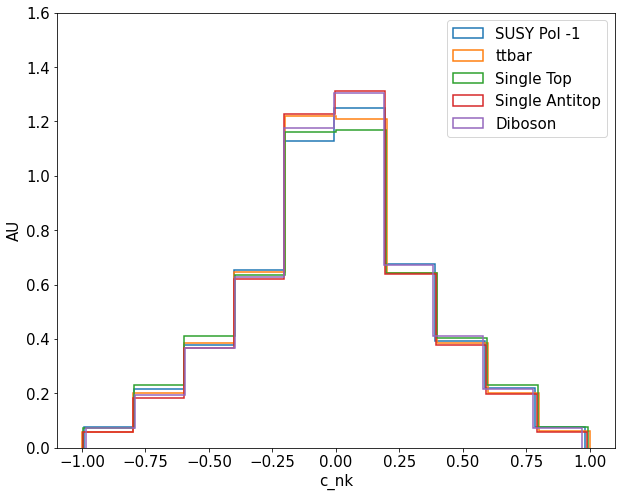

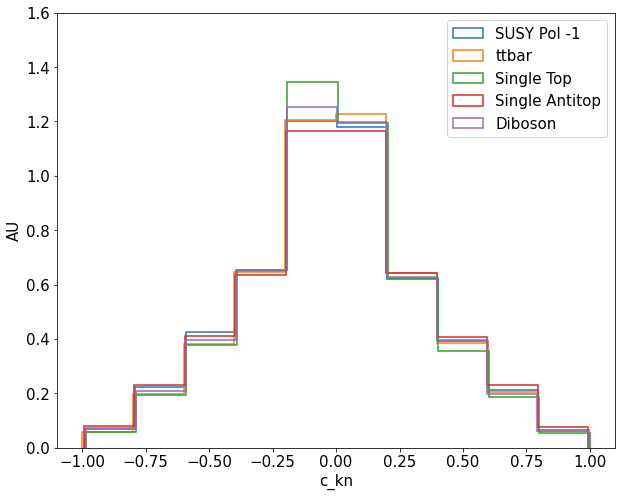

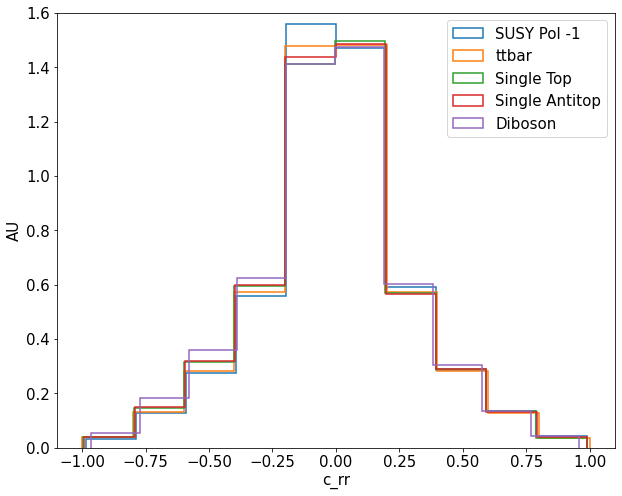

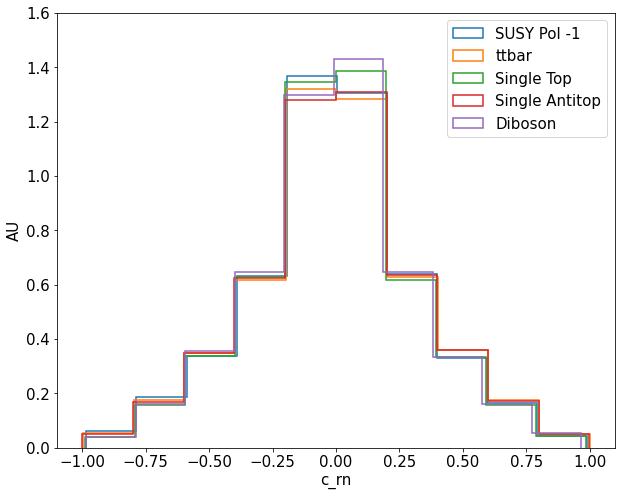

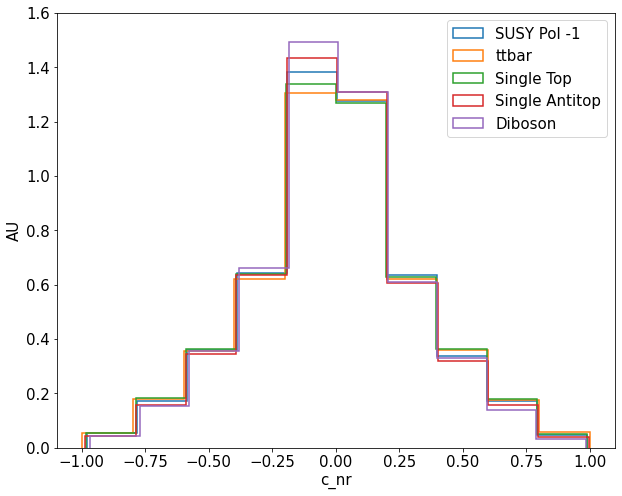

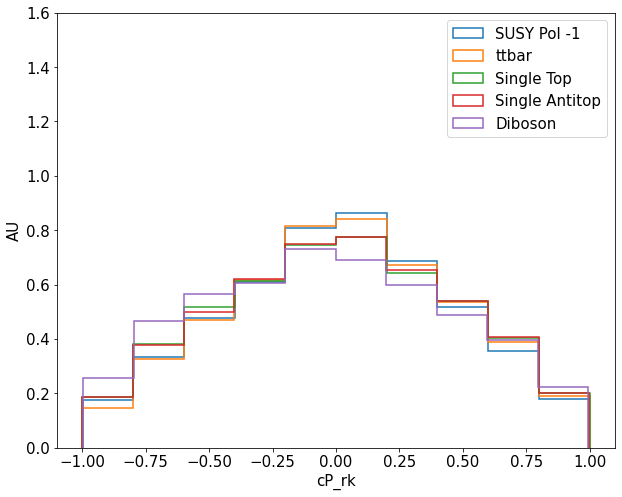

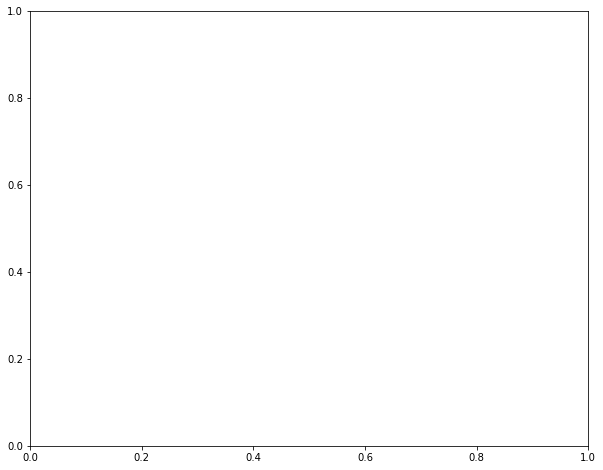

In [36]:
x_labels = sig_df.columns
count    = 0

for i in sig_df.columns :
    print(i)
    plt.figure(figsize=(10,8))
    # Plot the histograms
    plt.hist(sig_df[i], histtype='step', density=True, linewidth=1.5, label='SUSY Pol -1', weights=sc_weight)
    plt.hist(tt_df[i] , histtype='step', density=True, linewidth=1.5, label='ttbar')
    plt.hist(st_df[i] , histtype='step', density=True, linewidth=1.5, label='Single Top')
    plt.hist(sat_df[i], histtype='step', density=True, linewidth=1.5, label='Single Antitop')
    plt.hist(vv_df[i] , histtype='step', density=True, linewidth=1.5, label='Diboson')
    
    # Formatting
    if 'c' in x_labels[count] :
        plt.ylim(0,1.6)
    else :
        plt.ylim(0,0.8)
    plt.xlabel(x_labels[count], fontsize=15)
    plt.ylabel('AU', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15)
    
    img_name = 'Images/Mstop_227_5_' + str(x_labels[count]) + '.jpg' 
    count   += 1
    plt.savefig(img_name)

In [42]:
# Standardize
sig_mean = sig_df.mean()
sig_std  = sig_df.std()

tt_mean = tt_df.mean()
tt_std  = tt_df.std()

st_mean = st_df.mean()
st_std  = st_df.std()

vv_mean = vv_df.mean()
vv_std  = vv_df.std()

sat_mean = sat_df.mean()
sat_std  = sat_df.std()

sig_df = (sig_df - sig_mean)/ sig_std
tt_df  = (tt_df  - tt_mean)/ tt_std
st_df  = (st_df  - st_mean)/ st_std
vv_df  = (vv_df  - vv_mean)/ vv_std
sat_df = (sat_df  - sat_mean)/ sat_std

In [43]:
# Lumi weights
w_tt  = 17.994815 * np.ones(len(tt_df))
w_st  = 8.706901  * np.ones(len(st_df))
w_sat = 8.706901  * np.ones(len(sat_df))
w_vv  = 2.580743  * np.ones(len(vv_df))
w_SUSY= 14.38951  * np.ones(len(sig_df))

In [44]:
w_SUSY = np.multiply(np.array(sc_weight), w_SUSY)

In [45]:
# Set both to equal sizes 
# Reducing the bkg dataframe size

sig_df_train = sig_df[1:13000]
tt_df_train  = tt_df[1:20000]
st_df_train  = st_df[1:5000]
vv_df_train  = vv_df[1:2000]
sat_df_train = sat_df[1:5000]

In [46]:
sig_df_wt    = w_SUSY[1:13000]
tt_df_wt     = w_tt[1:20000]
st_df_wt     = w_st[1:5000]
vv_df_wt     = w_vv[1:2000]
sat_df_wt    = w_sat[1:5000]

In [47]:
bkgList = [tt_df_train, st_df_train, sat_df_train, vv_df_train]  # List of your dataframes
bkgWts  = [tt_df_wt   , st_df_wt   , sat_df_wt   , vv_df_wt]

bkg_df_train = pd.concat(bkgList)
bkg_df_wt    = np.concatenate(bkgWts)

signal = sig_df_train.values
bkg    = bkg_df_train.values

sig_label = np.ones(len(signal))
bkg_label = np.zeros(len(bkg))

data      = np.concatenate((signal,bkg))
label     = np.concatenate((sig_label,bkg_label))
sample_wts= np.concatenate((sig_df_wt, bkg_df_wt))

In [48]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2, shuffle=True)
skf.get_n_splits(data, label)
skf.split(data, label)

<generator object _BaseKFold.split at 0x7f8c32e9e740>

In [49]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]
    x_train_wt, x_test_wt = sample_wts[train_index], sample_wts[test_index]

TRAIN: [    3     5     7 ... 44990 44991 44993] TEST: [    0     1     2 ... 44988 44992 44994]
TRAIN: [    0     1     2 ... 44988 44992 44994] TEST: [    3     5     7 ... 44990 44991 44993]


In [50]:
idx      = np.random.permutation(len(x_train))
x_train  = x_train[idx]
y_train  = y_train[idx]
x_train_wt = x_train_wt[idx]

In [58]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout , BatchNormalization
from skopt        import gp_minimize

model = Sequential()
model.add(Dense(250, input_dim = 39 ,activation='relu'))
model.add(Dropout(0.4))
#model.add(BatchNormalization())
#model.add(Dense(100, input_dim = 100 ,activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 250)               10000     
_________________________________________________________________
dropout_5 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 251       
Total params: 10,251
Trainable params: 10,251
Non-trainable params: 0
_________________________________________________________________


In [59]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [60]:
hist = model.fit(x_train, y_train, sample_weight=x_train_wt, batch_size=40, epochs=1000,verbose=1, shuffle=True, validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min'),
                  ModelCheckpoint(filepath='model2.h5', verbose=0)])

Epoch 1/1000
450/450 [==============================] - 1s 2ms/step - loss: 8.8578 - accuracy: 0.6637 - val_loss: 8.4009 - val_accuracy: 0.7049
Epoch 2/1000
450/450 [==============================] - 1s 1ms/step - loss: 8.3994 - accuracy: 0.7066 - val_loss: 8.3862 - val_accuracy: 0.7051
Epoch 3/1000
450/450 [==============================] - 1s 1ms/step - loss: 8.2862 - accuracy: 0.7083 - val_loss: 8.3558 - val_accuracy: 0.7049
Epoch 4/1000
450/450 [==============================] - 1s 1ms/step - loss: 8.0395 - accuracy: 0.7108 - val_loss: 8.3473 - val_accuracy: 0.7042
Epoch 5/1000
450/450 [==============================] - 1s 1ms/step - loss: 8.0599 - accuracy: 0.7145 - val_loss: 8.4120 - val_accuracy: 0.7038
Epoch 6/1000
450/450 [==============================] - 1s 1ms/step - loss: 8.1626 - accuracy: 0.7085 - val_loss: 8.3459 - val_accuracy: 0.7044
Epoch 7/1000
450/450 [==============================] - 1s 1ms/step - loss: 7.9788 - accuracy: 0.7138 - val_loss: 8.2924 - val_accuracy:

450/450 [==============================] - 0s 1ms/step - loss: 6.5699 - accuracy: 0.7354 - val_loss: 6.6822 - val_accuracy: 0.7331
Epoch 58/1000
450/450 [==============================] - 0s 1ms/step - loss: 6.6370 - accuracy: 0.7367 - val_loss: 6.6848 - val_accuracy: 0.7264
Epoch 59/1000
450/450 [==============================] - 1s 1ms/step - loss: 6.3220 - accuracy: 0.7433 - val_loss: 6.7828 - val_accuracy: 0.7240
Epoch 60/1000
450/450 [==============================] - 0s 1ms/step - loss: 6.6894 - accuracy: 0.7387 - val_loss: 6.7079 - val_accuracy: 0.7313
Epoch 61/1000
450/450 [==============================] - 0s 1ms/step - loss: 6.5583 - accuracy: 0.7441 - val_loss: 6.6914 - val_accuracy: 0.7336
Epoch 62/1000
450/450 [==============================] - 1s 1ms/step - loss: 6.3647 - accuracy: 0.7404 - val_loss: 6.7040 - val_accuracy: 0.7267
Epoch 63/1000
450/450 [==============================] - 1s 1ms/step - loss: 6.3958 - accuracy: 0.7491 - val_loss: 6.5604 - val_accuracy: 0.7420

450/450 [==============================] - 1s 1ms/step - loss: 5.0158 - accuracy: 0.7952 - val_loss: 4.7684 - val_accuracy: 0.8182
Epoch 114/1000
450/450 [==============================] - 0s 1ms/step - loss: 4.9976 - accuracy: 0.8008 - val_loss: 4.7331 - val_accuracy: 0.8204
Epoch 115/1000
450/450 [==============================] - 1s 1ms/step - loss: 4.9129 - accuracy: 0.7952 - val_loss: 4.8202 - val_accuracy: 0.8082
Epoch 116/1000
450/450 [==============================] - 0s 1ms/step - loss: 5.0261 - accuracy: 0.7968 - val_loss: 4.6301 - val_accuracy: 0.8240
Epoch 117/1000
450/450 [==============================] - 0s 1ms/step - loss: 4.7865 - accuracy: 0.8049 - val_loss: 4.7369 - val_accuracy: 0.8040
Epoch 118/1000
450/450 [==============================] - 0s 1ms/step - loss: 4.8323 - accuracy: 0.8000 - val_loss: 4.5974 - val_accuracy: 0.8193
Epoch 119/1000
450/450 [==============================] - 1s 1ms/step - loss: 4.8888 - accuracy: 0.8027 - val_loss: 4.4783 - val_accuracy: 

450/450 [==============================] - 1s 1ms/step - loss: 3.6986 - accuracy: 0.8536 - val_loss: 3.1959 - val_accuracy: 0.8849
Epoch 170/1000
450/450 [==============================] - 0s 1ms/step - loss: 3.7795 - accuracy: 0.8433 - val_loss: 3.3165 - val_accuracy: 0.8824
Epoch 171/1000
450/450 [==============================] - 0s 1ms/step - loss: 3.7128 - accuracy: 0.8494 - val_loss: 3.2435 - val_accuracy: 0.8869
Epoch 172/1000
450/450 [==============================] - 1s 1ms/step - loss: 3.6139 - accuracy: 0.8545 - val_loss: 3.2797 - val_accuracy: 0.8784
Epoch 173/1000
450/450 [==============================] - 1s 1ms/step - loss: 3.6720 - accuracy: 0.8500 - val_loss: 3.1240 - val_accuracy: 0.8911
Epoch 174/1000
450/450 [==============================] - 0s 1ms/step - loss: 3.5696 - accuracy: 0.8510 - val_loss: 3.4049 - val_accuracy: 0.8673
Epoch 175/1000
450/450 [==============================] - 1s 1ms/step - loss: 3.8069 - accuracy: 0.8456 - val_loss: 3.1358 - val_accuracy: 

450/450 [==============================] - 0s 1ms/step - loss: 2.8495 - accuracy: 0.8830 - val_loss: 2.2121 - val_accuracy: 0.9202
Epoch 226/1000
450/450 [==============================] - 0s 1ms/step - loss: 2.9073 - accuracy: 0.8820 - val_loss: 2.1230 - val_accuracy: 0.9307
Epoch 227/1000
450/450 [==============================] - 0s 1ms/step - loss: 2.7859 - accuracy: 0.8887 - val_loss: 2.2387 - val_accuracy: 0.9262
Epoch 228/1000
450/450 [==============================] - 1s 1ms/step - loss: 2.9478 - accuracy: 0.8864 - val_loss: 2.1505 - val_accuracy: 0.9309
Epoch 229/1000
450/450 [==============================] - 0s 1ms/step - loss: 2.7006 - accuracy: 0.8924 - val_loss: 2.2575 - val_accuracy: 0.9251
Epoch 230/1000
450/450 [==============================] - 0s 1ms/step - loss: 2.9880 - accuracy: 0.8824 - val_loss: 2.2757 - val_accuracy: 0.9251
Epoch 231/1000
450/450 [==============================] - 0s 1ms/step - loss: 2.8815 - accuracy: 0.8833 - val_loss: 2.1043 - val_accuracy: 

450/450 [==============================] - 1s 1ms/step - loss: 2.3924 - accuracy: 0.9034 - val_loss: 1.5614 - val_accuracy: 0.9509
Epoch 282/1000
450/450 [==============================] - 0s 1ms/step - loss: 2.2776 - accuracy: 0.9069 - val_loss: 1.6356 - val_accuracy: 0.9476
Epoch 283/1000
450/450 [==============================] - 0s 1ms/step - loss: 2.5481 - accuracy: 0.9038 - val_loss: 1.9962 - val_accuracy: 0.9309
Epoch 284/1000
450/450 [==============================] - 1s 1ms/step - loss: 2.4295 - accuracy: 0.9027 - val_loss: 1.6877 - val_accuracy: 0.9496
Epoch 285/1000
450/450 [==============================] - 1s 1ms/step - loss: 2.3127 - accuracy: 0.9090 - val_loss: 1.4709 - val_accuracy: 0.9527
Epoch 286/1000
450/450 [==============================] - 0s 1ms/step - loss: 2.2023 - accuracy: 0.9086 - val_loss: 1.7285 - val_accuracy: 0.9456
Epoch 287/1000
450/450 [==============================] - 1s 1ms/step - loss: 2.3456 - accuracy: 0.9060 - val_loss: 1.5010 - val_accuracy: 

450/450 [==============================] - 0s 1ms/step - loss: 2.1251 - accuracy: 0.9172 - val_loss: 1.2770 - val_accuracy: 0.9571
Epoch 338/1000
450/450 [==============================] - 1s 1ms/step - loss: 2.0201 - accuracy: 0.9231 - val_loss: 1.3146 - val_accuracy: 0.9580
Epoch 339/1000
450/450 [==============================] - 1s 1ms/step - loss: 2.0543 - accuracy: 0.9172 - val_loss: 1.3382 - val_accuracy: 0.9589
Epoch 340/1000
450/450 [==============================] - 1s 1ms/step - loss: 2.1282 - accuracy: 0.9160 - val_loss: 1.2401 - val_accuracy: 0.9627
Epoch 341/1000
450/450 [==============================] - 0s 1ms/step - loss: 1.9812 - accuracy: 0.9284 - val_loss: 1.2521 - val_accuracy: 0.9582
Epoch 342/1000
450/450 [==============================] - 1s 1ms/step - loss: 1.9545 - accuracy: 0.9219 - val_loss: 1.1425 - val_accuracy: 0.9658
Epoch 343/1000
450/450 [==============================] - 1s 1ms/step - loss: 1.9387 - accuracy: 0.9215 - val_loss: 1.0492 - val_accuracy: 

450/450 [==============================] - 0s 1ms/step - loss: 1.5993 - accuracy: 0.9382 - val_loss: 1.0191 - val_accuracy: 0.9709
Epoch 394/1000
450/450 [==============================] - 0s 1ms/step - loss: 1.5935 - accuracy: 0.9386 - val_loss: 0.9028 - val_accuracy: 0.9711
Epoch 395/1000
450/450 [==============================] - 1s 1ms/step - loss: 1.7173 - accuracy: 0.9365 - val_loss: 1.0440 - val_accuracy: 0.9693
Epoch 396/1000
450/450 [==============================] - 0s 1ms/step - loss: 1.6279 - accuracy: 0.9332 - val_loss: 1.0629 - val_accuracy: 0.9687
Epoch 397/1000
450/450 [==============================] - 1s 1ms/step - loss: 1.7669 - accuracy: 0.9338 - val_loss: 0.9045 - val_accuracy: 0.9676
Epoch 398/1000
450/450 [==============================] - 1s 1ms/step - loss: 1.7349 - accuracy: 0.9308 - val_loss: 0.8077 - val_accuracy: 0.9791
Epoch 399/1000
450/450 [==============================] - 1s 1ms/step - loss: 1.6385 - accuracy: 0.9363 - val_loss: 1.0251 - val_accuracy: 

In [23]:
# serialize model to JSON
model_json = model.to_json()
with open("Models/Mstop_227_5_mchi_60.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Models/Mstop_227_5_mchi_60.h5")
print("Saved model to disk")

Saved model to disk


In [18]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch', fontsize=17)
    plt.ylabel('Loss' , fontsize=17)
    plt.tick_params(axis="y", labelsize=15)
    plt.tick_params(axis="x", labelsize=15)
    plt.title('Cross Entropy Loss by Epoch', fontsize=17)
    color='C0'
    do_acc=False
    for label,loss in histories:
        #color = tuple(np.random.random(3))
        #colors.append(color)
        l = 'Training set loss'
        vl= 'Validation set loss'
        if 'accuracy' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['accuracy'][-1])
            do_acc = True
        if 'val_accuracy' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_accuracy'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color='C0')
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color='C0')

    plt.legend(fontsize=17)
    #plt.yscale('log')
    plt.show()
    
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch', fontsize=17)
    plt.ylabel('Accuracy' , fontsize=17)
    plt.tick_params(axis="y", labelsize=15)
    plt.tick_params(axis="x", labelsize=15)
    for i,(label,loss) in enumerate(histories):
        #color = colors[i]
        if 'accuracy' in loss.history:
            plt.plot(loss.history['accuracy'], lw=2, label=label+" accuracy", color=color)
        if 'val_accuracy' in loss.history:
            plt.plot(loss.history['val_accuracy'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(fontsize=17)
    plt.show()

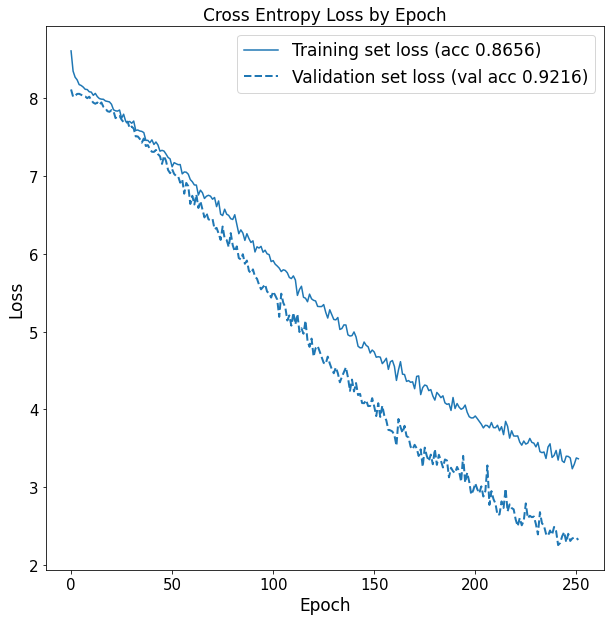

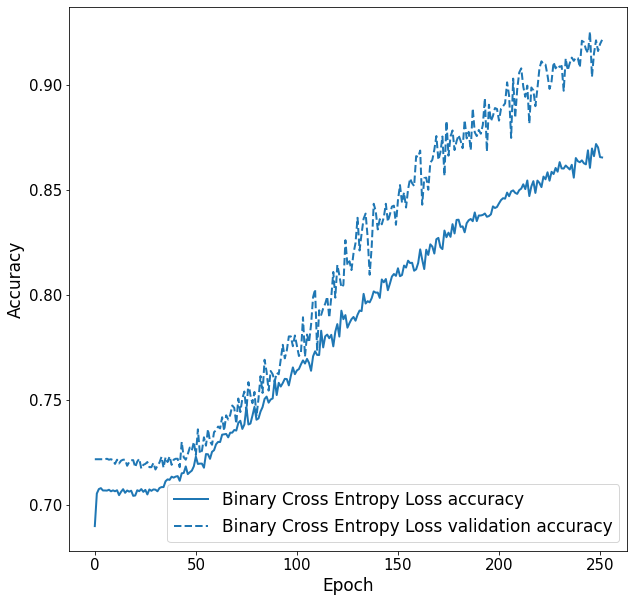

In [19]:
show_losses( [("Binary Cross Entropy Loss", hist)])

In [20]:
from sklearn.metrics import roc_curve
y_pred_train = model.predict(x_train).ravel()
y_pred_test  = model.predict(x_test).ravel()

fpr_keras_train, tpr_keras_train, thresholds_keras = roc_curve(y_train, y_pred_train)
fpr_keras_test , tpr_keras_test , thresholds_keras = roc_curve(y_test , y_pred_test)

In [21]:
from sklearn.metrics import auc
auc_keras_test  = auc(fpr_keras_test, tpr_keras_test)
auc_keras_train = auc(fpr_keras_train, tpr_keras_train)

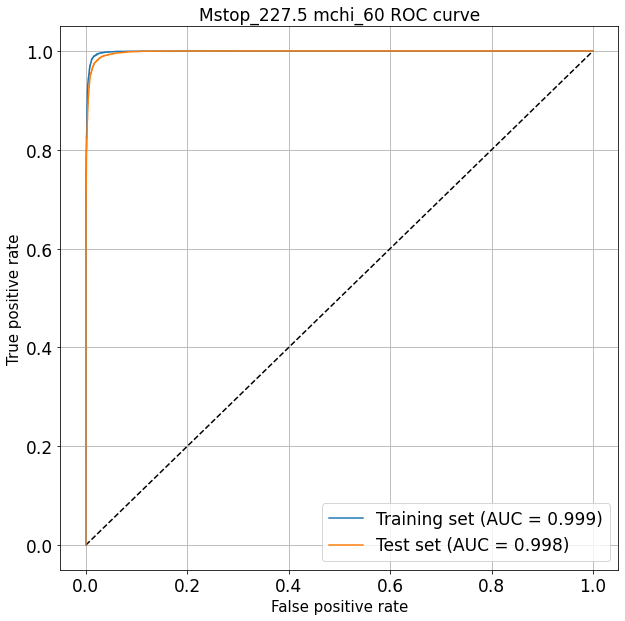

In [55]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_train, tpr_keras_train, label='Training set (AUC = {:.3f})'.format(auc_keras_train))
plt.plot(fpr_keras_test , tpr_keras_test , label='Test set (AUC = {:.3f})'.format(auc_keras_test))
plt.tick_params(axis="y", labelsize=17)
plt.tick_params(axis="x", labelsize=17)
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate' , fontsize=15)
plt.title('Mstop_227.5 mchi_60 ROC curve', fontsize=17)
plt.legend(loc='lower right', fontsize=17)
plt.grid()
#plt.savefig('ROC Mstop 227.5 Mchi 60.jpg')
plt.show()

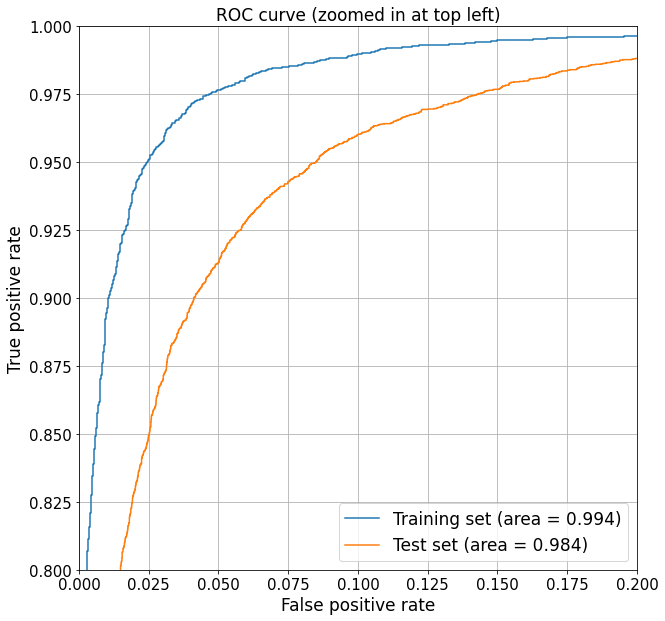

In [22]:
# Zoom in view of the upper left corner.
plt.figure(figsize=(10,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_train, tpr_keras_train, label='Training set (area = {:.3f})'.format(auc_keras_train))
plt.plot(fpr_keras_test , tpr_keras_test , label='Test set (area = {:.3f})'.format(auc_keras_test))
plt.ylabel('True positive rate' , fontsize=17)
plt.xlabel('False positive rate', fontsize=17)
plt.tick_params(axis="y", labelsize=15)
plt.tick_params(axis="x", labelsize=15)
plt.title('ROC curve (zoomed in at top left)', fontsize=17)
plt.legend(loc='best', fontsize=17)
plt.grid()
plt.show()

In [24]:
tt_pred  = model.predict(tt_df[20000:]) 
st_pred  = model.predict(st_df[5000:])
sat_pred = model.predict(sat_df[5000:])
vv_pred  = model.predict(vv_df[2000:]) 
si_pred  = model.predict(sig_df[13000:])

2021-05-07 04:10:31.904078: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 366416544 exceeds 10% of free system memory.


In [25]:
tt_pred_wt  = w_tt[20000:]
st_pred_wt  = w_st[5000:]
sat_pred_wt = w_sat[5000:]
vv_pred_wt  = w_vv[2000:]
si_pred_wt  = w_SUSY[13000:]

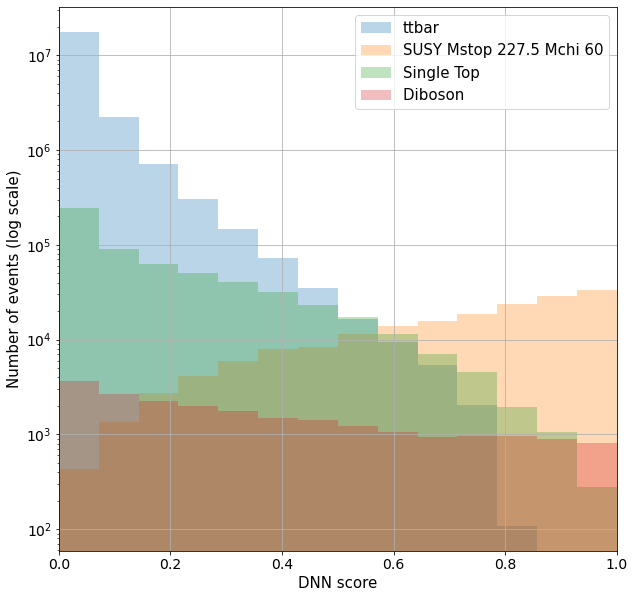

In [26]:
binning = np.linspace(0,1,15)
plt.figure(figsize=(10,10))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(tt_pred, bins=binning, alpha=0.3, weights= tt_pred_wt, label='ttbar')
plt.hist(si_pred, bins=binning, alpha=0.3, weights= si_pred_wt, label='SUSY Mstop 227.5 Mchi 60')
plt.hist(st_pred, bins=binning, alpha=0.3, weights= st_pred_wt, label='Single Top')
plt.hist(vv_pred, bins=binning, alpha=0.3, weights= vv_pred_wt, label='Diboson ')
#plt.hist(sat_pred, bins=binning, alpha=0.3, label='Single Antitop')
plt.yscale('log')
plt.xlim(0,1)
plt.xlabel('DNN score', fontsize=15)
plt.ylabel('Number of events (log scale)', fontsize=15)
plt.grid()
plt.legend(loc='best', fontsize=15)
#plt.savefig('DNN_score_Mstop_227_5_Mchi_60.jpg')

In [46]:
np.savetxt('DNN_pred/Mstop_227_5_mchi_60_SUSY_pred.txt', si_pred)
np.savetxt('DNN_pred/Mstop_227_5_mchi_60_tt_pred.txt'  , tt_pred)
np.savetxt('DNN_pred/Mstop_227_5_mchi_60_st_pred.txt'  , st_pred)
np.savetxt('DNN_pred/Mstop_227_5_mchi_60_sat_pred.txt' , sat_pred)
np.savetxt('DNN_pred/Mstop_227_5_mchi_60_vv_pred.txt'  , vv_pred)

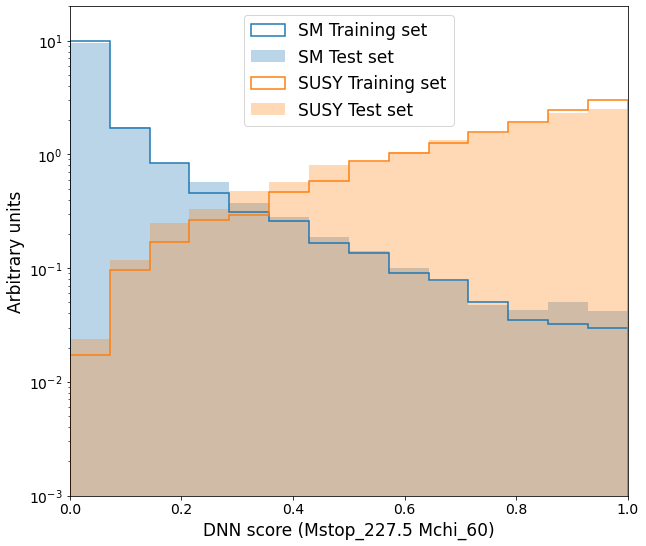

In [23]:
c0 = 'C0'
c1 = 'C1'
binning = np.linspace(0,1,15)
plt.figure(figsize=(10,9))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(y_pred_train[y_train == 0], bins=binning, label='SM Training set', histtype='step', linestyle='solid', linewidth=1.5, density=True, color=c0)
plt.hist(y_pred_test[y_test == 0]  , bins=binning, label='SM Test set'    , alpha=0.3, linewidth=1.5, density=True , color=c0)
plt.hist(y_pred_train[y_train == 1], bins=binning, label='SUSY Training set', histtype='step' , linestyle='solid', linewidth=1.5, density=True, color=c1)
plt.hist(y_pred_test[y_test == 1]  , bins=binning, label='SUSY Test set ', alpha=0.3, linewidth=1.5, density=True, color=c1)

plt.yscale('log')
plt.ylim(0.001, 20)
plt.xlim(0,1)
plt.xlabel('DNN score (Mstop_227.5 Mchi_60)', fontsize=17)
plt.ylabel('Arbitrary units', fontsize=17)
plt.legend(loc='upper center', fontsize=17)
#plt.savefig('Train vs test Mstop_227.5 Mchi_60.jpg')

In [24]:
def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()
    sns.set(font_scale=1.4)
    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(15, 12))

    # Add diverging colormap from red to blue
    #cmap = sns.diverging_palette(250, 10, as_cmap=True)
    #cmap  = sns.color_palette("coolwarm")
    cmap = sns.diverging_palette(0,255,sep=1, as_cmap=True)
                                 
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        hm = sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax, vmin=-1, vmax=1)
        plt.title('Correlation matrix for input features', fontsize=30)
        plt.savefig('ip_features_corr.png')
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax, vmin=-1, vmax=1)

/home/amandeephy/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/amandeephy/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


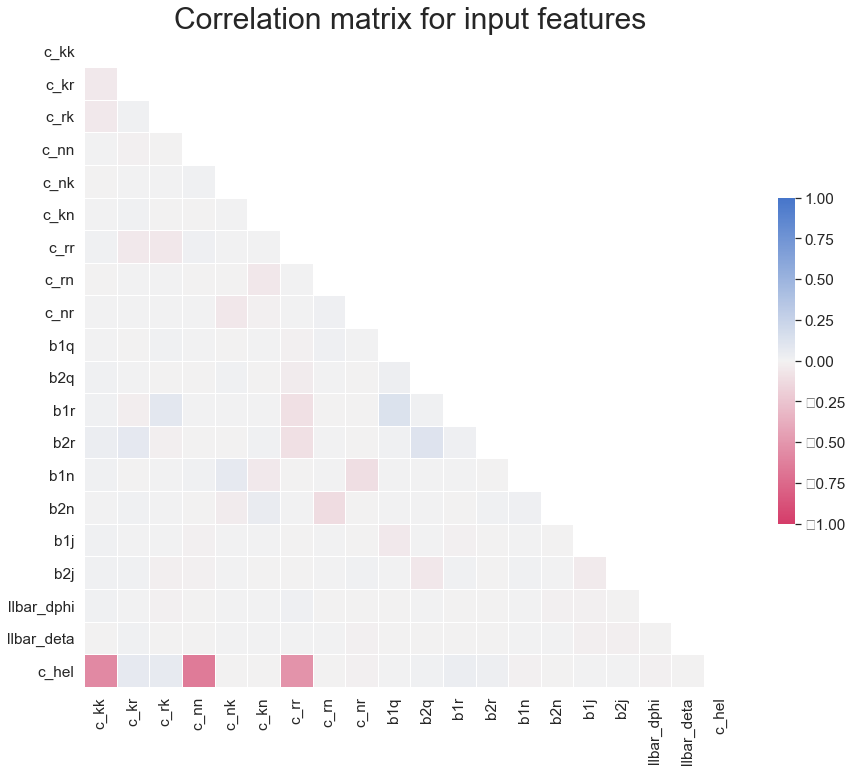

In [25]:
corr = sig_df_train.corr()
CorrMtx(corr, dropDuplicates = True)

In [72]:
print(model.layers[0].weights)
print(model.layers[0].bias.numpy())
print(model.layers[0].bias_initializer)

[<tf.Variable 'dense_16/kernel:0' shape=(39, 150) dtype=float32, numpy=
array([[ 3.81187536e-02, -9.05988887e-02,  1.21316463e-01, ...,
        -1.50077678e-02,  1.31742075e-01, -4.79170084e-01],
       [-1.61985144e-01, -1.25957895e-02,  1.50437936e-01, ...,
         1.67071000e-01, -5.56776412e-02,  2.90255517e-01],
       [-5.27780643e-03, -1.36014611e-01, -3.94791305e-01, ...,
         4.49587516e-02,  1.55111924e-01, -1.17269784e-01],
       ...,
       [-6.10952638e-02, -1.97931571e-04, -5.36210053e-02, ...,
        -1.58696901e-02,  2.94308197e-02,  5.88998795e-02],
       [ 1.02362201e-01,  3.57543379e-02,  1.91298410e-01, ...,
        -2.78218836e-03, -8.93230736e-02,  2.30878498e-02],
       [-7.63779432e-02, -3.34288627e-01, -1.88060880e-01, ...,
         8.87432545e-02,  3.50912064e-02,  3.51420194e-01]], dtype=float32)>, <tf.Variable 'dense_16/bias:0' shape=(150,) dtype=float32, numpy=
array([-1.1747636 , -1.2481533 , -1.4592422 , -0.9665628 , -0.21968329,
       -1.579971

In [ ]:
import shap